### Imports 

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
import lightgbm as lgb

In [4]:
from scipy.stats import ttest_rel

### Const and Func

In [5]:
np.random.seed(42)

In [6]:
path = Path('data/dataset/')

In [7]:
path

PosixPath('data/dataset')

In [8]:
! ls {path}

 bs_avg_kpi.csv   '!dataset_fields_description.xlsx'   test
 bs_chnn_kpi.csv   sample-submit-zero.csv	       train


In [9]:
! ls {path/'train'}

subs_bs_consumption_train.csv	 subs_csi_train.csv
subs_bs_data_session_train.csv	 subs_features_train.csv
subs_bs_voice_session_train.csv


In [10]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [11]:
def margin_of_error(z, data):
    n, std = len(data), data.std()
    z_critical = scipy.stats.norm.ppf(q=z)
    return z_critical * (std / np.sqrt(n))

### Loads

In [12]:
train_ids = pd.read_csv(path/'train/subs_csi_train.csv', sep=';')

In [13]:
test_ids = pd.read_csv(path/'test/subs_csi_test.csv', sep=';')

In [14]:
features_train = pd.read_csv(path/'train/subs_features_train.csv', sep=';', decimal=',', 
                              parse_dates=['SNAP_DATE'], infer_datetime_format=True, dayfirst=True)

In [15]:
features_test = pd.read_csv(path/'test/subs_features_test.csv', sep=';', decimal=',', 
                              parse_dates=['SNAP_DATE'], infer_datetime_format=True, dayfirst=True)

In [16]:
# convert to months (int)
features_train.SNAP_DATE = features_train.SNAP_DATE.dt.month

In [17]:
# convert to months (int)
features_test.SNAP_DATE = features_test.SNAP_DATE.dt.month

###  Data processing

In [17]:
train_ids.SK_ID.nunique(), features_train.SK_ID.nunique()

(4222, 4222)

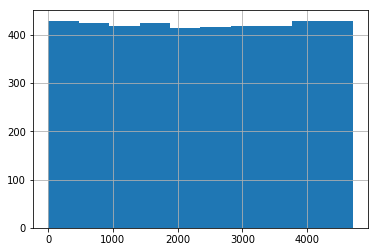

In [18]:
train_ids.SK_ID.hist();

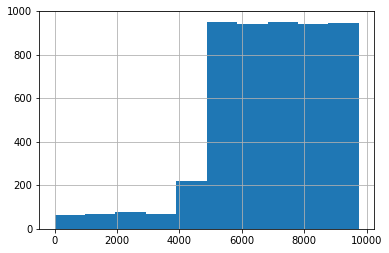

In [19]:
test_ids.SK_ID.hist();

#### Id-based validation

In [18]:
features_test.SNAP_DATE.unique()

array([10,  7,  6,  1,  8,  4,  5, 11,  9,  2, 12,  3])

In [160]:
raw_train = features_train[features_train.SNAP_DATE.isin([1,2,3,4,5])].copy()
raw_test = features_test[features_test.SNAP_DATE.isin([1,2,3,4,5])].copy()

In [20]:
raw_train_other = features_train[features_train.SNAP_DATE.isin([6,7,8,9,10,11,12])].copy()
raw_test_other = features_test[features_test.SNAP_DATE.isin([6,7,8,9,10,11,12])].copy()

### Aggregation

In [161]:
raw_train.head()

,SNAP_DATE,COM_CAT#1,SK_ID,COM_CAT#2,COM_CAT#3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT#7,COM_CAT#8,...,COM_CAT#25,COM_CAT#26,COM_CAT#27,COM_CAT#28,COM_CAT#29,COM_CAT#30,COM_CAT#31,COM_CAT#32,COM_CAT#33,COM_CAT#34
570,1,4,238,75,5,2,1,8.0,1,945.0,...,1,1,0.009408,0.016091,0.000000,0.0,0.043079,0.027579,0.103896,3.0
571,1,4,1293,70,5,2,1,6.0,1,720.0,...,1,1,0.001875,0.001785,0.004100,0.0,0.060689,0.027579,0.103896,7.0
572,1,4,1620,47,5,2,1,7.0,1,1620.0,...,1,1,0.005866,0.002898,0.000000,0.0,0.287902,0.027579,0.103896,1.0
573,1,4,1393,38,5,2,1,6.0,3,1399.0,...,1,1,0.020422,0.012353,0.000000,0.0,0.025244,0.027579,0.103896,3.0
574,1,4,624,36,5,2,1,10.0,1,1627.0,...,1,1,0.016859,0.005389,0.113934,0.0,0.039788,0.027579,0.103896,2.0


In [162]:
for df in (raw_train, raw_test):
    df.drop('SNAP_DATE', axis=1, inplace=True)

In [163]:
for df in (raw_train, raw_test):
    print('====')
    for n, c in df.iteritems():
        if c.nunique() < 10:
            print(n, '-->', c.nunique(), c.dtype)

====
COM_CAT#1 --> 8 int64
BASE_TYPE --> 2 int64
ACT --> 2 int64
COM_CAT#7 --> 9 int64
DEVICE_TYPE_ID --> 7 float64
INTERNET_TYPE_ID --> 3 float64
COM_CAT#24 --> 8 object
COM_CAT#25 --> 2 int64
COM_CAT#26 --> 2 int64
====
COM_CAT#1 --> 8 int64
BASE_TYPE --> 2 int64
ACT --> 2 int64
COM_CAT#7 --> 9 int64
DEVICE_TYPE_ID --> 8 float64
INTERNET_TYPE_ID --> 3 float64
COM_CAT#24 --> 7 object
COM_CAT#25 --> 2 int64
COM_CAT#26 --> 2 int64


In [164]:
train_cats(raw_train)
apply_cats(raw_test, raw_train)

In [165]:
tr_gr = raw_train.groupby('SK_ID', as_index=False).agg(['mean', 'max', 'min'])
test_gr = raw_test.groupby('SK_ID', as_index=False).agg(['mean', 'max', 'min'])

In [166]:
for df in (tr_gr, test_gr):
    df.columns = ['_'.join(c) for c in df.columns]

In [167]:
# add contact date and labels
tr_gr = pd.merge(tr_gr, train_ids, on='SK_ID')

In [168]:
test_gr = pd.merge(test_ids, test_gr, on='SK_ID', how='left')

In [169]:
for df in (tr_gr, test_gr):
    df['CONTACT_DATE'] = pd.to_datetime(df['CONTACT_DATE'], format='%d.%m').dt.day

In [170]:
(tr_gr.shape,test_gr.shape)

((4213, 102), (5221, 101))

####  Aggregation for other set to get best set of months

In [86]:
for df in (raw_train_other, raw_test_other):
    df.drop('SNAP_DATE', axis=1, inplace=True)

In [87]:
for df in (raw_train_other, raw_test_other):
    print('====')
    for n, c in df.iteritems():
        if c.nunique() < 10:
            print(n, '-->', c.nunique(), c.dtype)

====
COM_CAT#1 --> 8 int64
BASE_TYPE --> 2 int64
ACT --> 2 int64
COM_CAT#7 --> 9 int64
DEVICE_TYPE_ID --> 8 float64
INTERNET_TYPE_ID --> 3 float64
COM_CAT#24 --> 1 object
COM_CAT#25 --> 1 int64
COM_CAT#26 --> 2 int64
====
COM_CAT#1 --> 8 int64
BASE_TYPE --> 2 int64
ACT --> 2 int64
COM_CAT#7 --> 9 int64
DEVICE_TYPE_ID --> 8 float64
INTERNET_TYPE_ID --> 3 float64
COM_CAT#24 --> 1 object
COM_CAT#25 --> 1 int64
COM_CAT#26 --> 2 int64


In [88]:
train_cats(raw_train_other)
apply_cats(raw_test_other, raw_train_other)

In [89]:
tr_gr_other = raw_train_other.groupby('SK_ID', as_index=False).agg(['size', 'mean', 'max', 'min'])
test_gr_other = raw_test_other.groupby('SK_ID', as_index=False).agg(['size', 'mean', 'max', 'min'])

In [90]:
for df in (tr_gr_other, test_gr_other):
    df.columns = ['_'.join(c) for c in df.columns]

In [91]:
# add contact date and labels
tr_gr_other = pd.merge(tr_gr_other, train_ids, on='SK_ID')

In [92]:
test_gr_other = pd.merge(test_ids, test_gr_other, on='SK_ID', how='left')

In [93]:
for df in (tr_gr_other, test_gr_other):
    df['CONTACT_DATE'] = pd.to_datetime(df['CONTACT_DATE'], format='%d.%m').dt.day

In [95]:
(tr_gr_other.shape,test_gr_other.shape)

((3976, 135), (5221, 134))

### Train

In [171]:
tr_gr = tr_gr.sample(frac=1).reset_index(drop=True)

In [172]:
df, y, nas = proc_df(tr_gr.drop(['SK_ID', 'CONTACT_DATE'], axis=1), 'CSI')

In [173]:
test, _, _ = proc_df(test_gr.drop(['SK_ID', 'CONTACT_DATE'], axis=1), na_dict=nas)

In [143]:
df_other, y_other, mas_other = proc_df(tr_gr_other, 'CSI')

In [144]:
test_other, _, _ = proc_df(test_gr_other, na_dict=mas_other)

In [174]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=10)
m.fit(df, y)
m.score(df, y)

0.9798243531924994

In [175]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 600
n_trn = len(df)-n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

In [176]:
X_train.shape, X_valid.shape, y_train.mean(), y_valid.mean()

((3613, 111), (600, 111), 0.15416551342374757, 0.16333333333333333)

In [177]:
raw_tr, raw_te = split_vals(tr_gr, n_trn)

In [178]:
def print_score(m):
    res = [metrics.roc_auc_score(y_train, m.predict_proba(X_train)[:,1]), 
           metrics.roc_auc_score(y_valid, m.predict_proba(X_valid)[:,1]),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [184]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=80, min_samples_leaf=50, max_features=0.5, 
                            oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.8682839538665439, 0.4616432230262623, 0.8458344865762524, 0.8366666666666667, 0.8458344865762524]


In [41]:
m = lgb.LGBMClassifier()
m.fit(X_train, y_train)
print_score(m)

[0.9999267361696205, 0.5385721730067743, 0.9834123222748815, 0.84]


### Feature Importance 

In [185]:
fi = rf_feat_importance(m, X_train)

In [186]:
fi[:10]

,cols,imp
85,COM_CAT#30_max,0.032842
89,COM_CAT#31_min,0.030160
30,REVENUE_mean,0.030053
59,COM_CAT#20_min,0.028926
36,VAS_mean,0.028451
87,COM_CAT#31_mean,0.028037
40,RENT_CHANNEL_max,0.027990
37,VAS_max,0.027198
63,COM_CAT#22_mean,0.025975
65,COM_CAT#22_min,0.025389


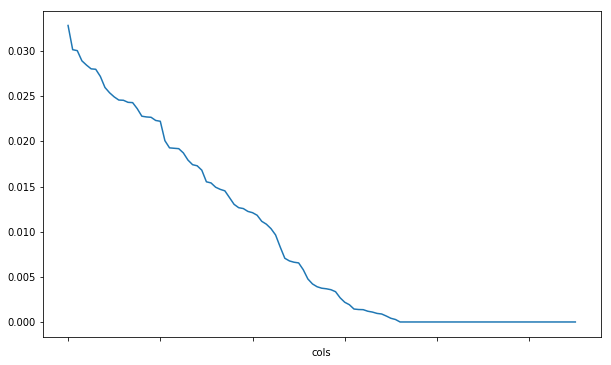

In [187]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [188]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

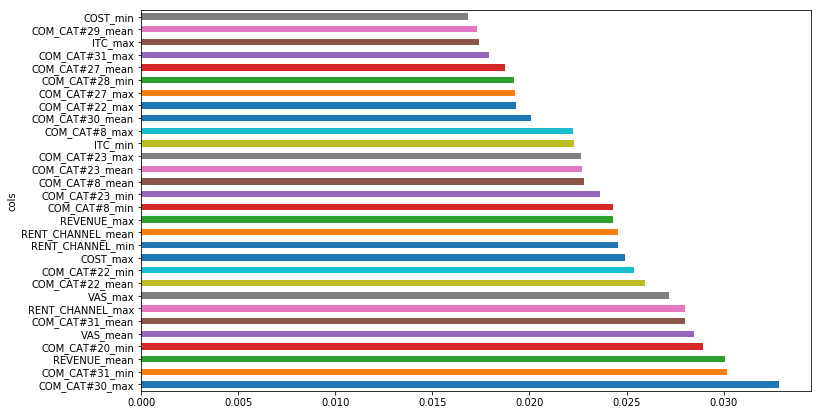

In [189]:
plot_fi(fi[:30]);

In [190]:
fi.describe()

,imp
count,111.000000
mean,0.009009
std,0.010198
min,0.000000
25%,0.000000
50%,0.003741
75%,0.017360
max,0.032842


In [191]:
to_keep = fi[fi.imp>0].cols; len(to_keep)

72

In [192]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [193]:
df_keep.shape

(4213, 72)

#### Hierarchical Clustering 

In [128]:
from scipy.cluster import hierarchy as hc

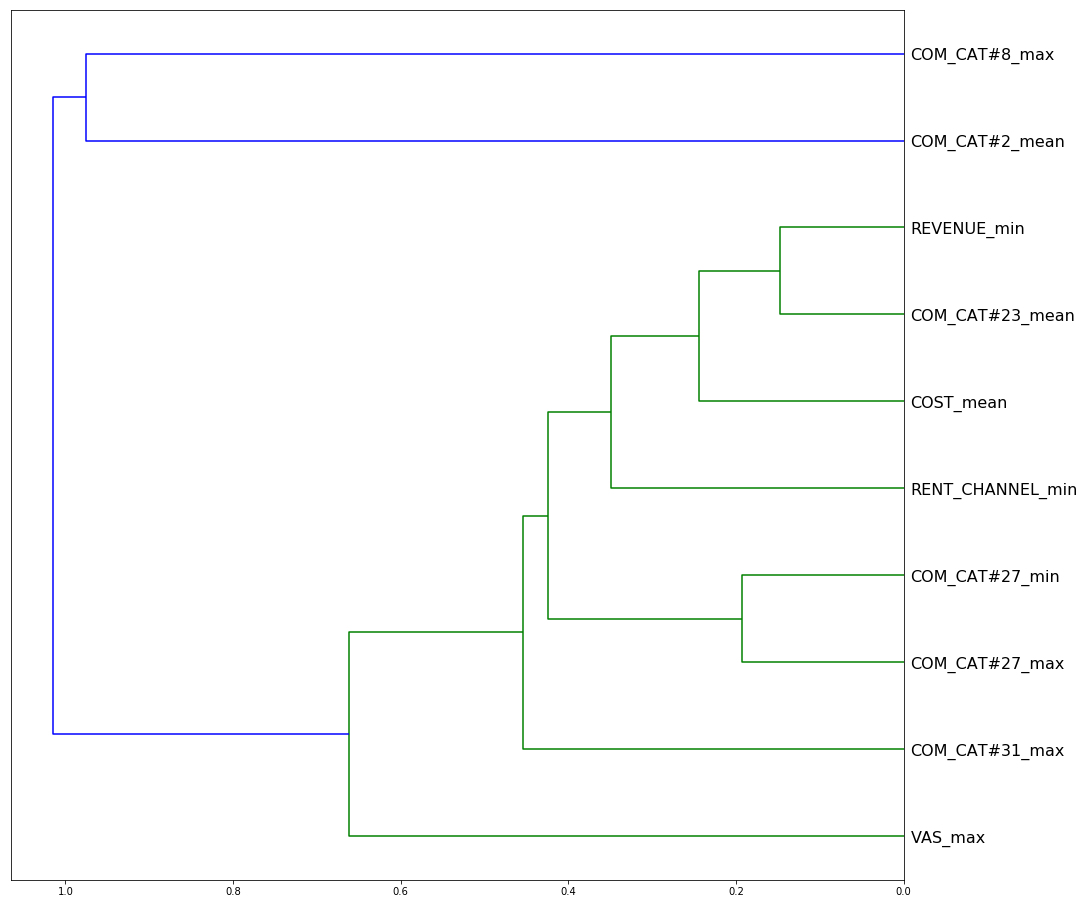

In [129]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,16))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [96]:
def get_oob(df):
    m = RandomForestClassifier(n_estimators=40, random_state=111, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [164]:
get_oob(df_keep)

0.8332345971563981

In [146]:
df_keep.columns

Index(['VAS_mean', 'COM_CAT#8_min', 'COM_CAT#27_max', 'COM_CAT#31_max',
       'COM_CAT#2_mean', 'COM_CAT#27_mean', 'COM_CAT#8_mean',
       'RENT_CHANNEL_min', 'CONTACT_DATE', 'COM_CAT#31_min', 'COM_CAT#29_max',
       'VAS_max', 'COM_CAT#23_mean', 'COST_max', 'COM_CAT#8_max',
       'RENT_CHANNEL_mean', 'RENT_CHANNEL_max', 'COM_CAT#31_mean',
       'COM_CAT#27_min', 'COST_mean', 'REVENUE_min'],
      dtype='object')

In [165]:
for c in ( 'VAS_mean', 'VAS_max', 'COM_CAT#27_max', 'COM_CAT#27_mean', 'COST_max', 'COST_mean'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

VAS_mean 0.8356042654028436
VAS_max 0.8332345971563981
COM_CAT#27_max 0.8353080568720379
COM_CAT#27_mean 0.8356042654028436
COST_max 0.8359004739336493
COST_mean 0.8350118483412322


In [166]:
to_drop =['COST_max', 'COM_CAT#27_mean', 'VAS_mean']
get_oob(df_keep.drop(to_drop, axis=1))

0.830568720379147

In [167]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [168]:
os.makedirs('data/tmp', exist_ok=True)

In [169]:
np.save('data/tmp/keep_cols.npy', np.array(df_keep.columns))

In [170]:
keep_cols = np.load('data/tmp/keep_cols.npy')

In [92]:
keep_cols = ['COM_CAT#2_mean', 'COM_CAT#31_max', 'COM_CAT#23_mean', 'COM_CAT#27_max',
           'REVENUE_min', 'COST_mean', 'VAS_max', 'COM_CAT#27_min',
           'RENT_CHANNEL_min', 'COM_CAT#8_max']

In [198]:
len(keep_cols)

11

In [93]:
df_keep = df_keep[keep_cols]
X_train, X_valid = split_vals(df_keep, n_trn)

#### Univariate plots on test - valid 

In [133]:
from featexp import get_univariate_plots

                                      Plots for RENT_CHANNEL_min                                      
                                           Train data plots                                           


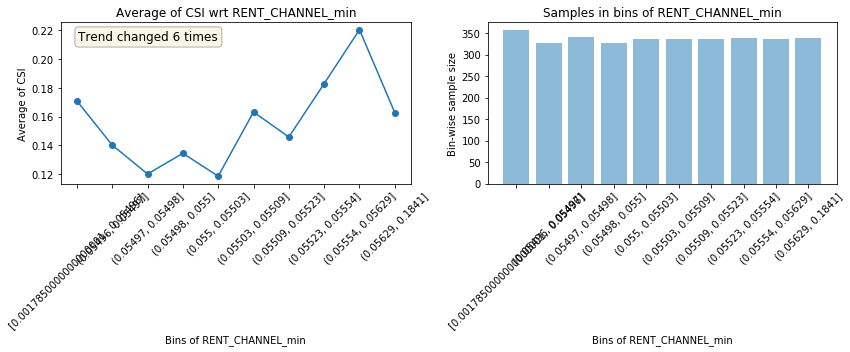

                                           Test data plots                                            


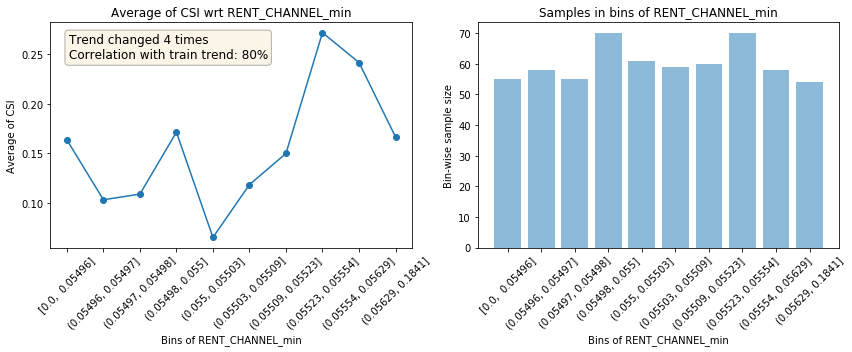

--------------------------------------------------------------------------------------------------------------


                                          Plots for VAS_max                                           
                                           Train data plots                                           


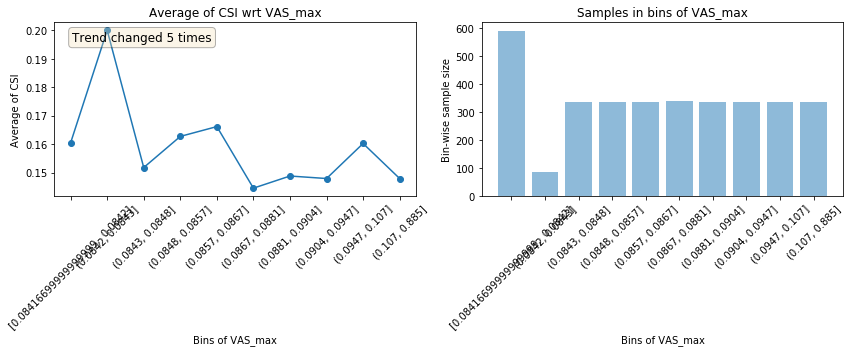

                                           Test data plots                                            


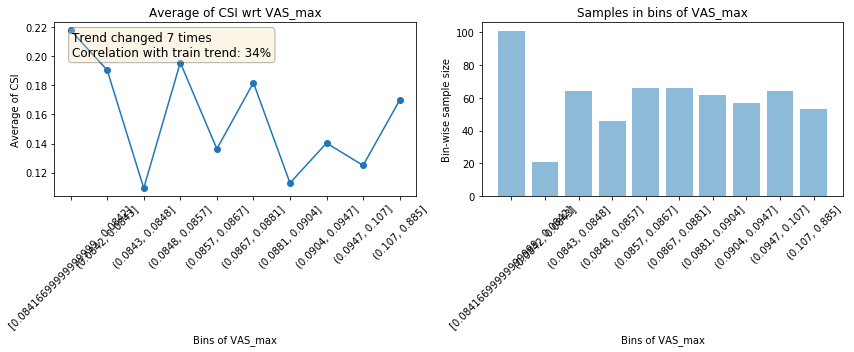

--------------------------------------------------------------------------------------------------------------


                                       Plots for COM_CAT#31_max                                       
                                           Train data plots                                           


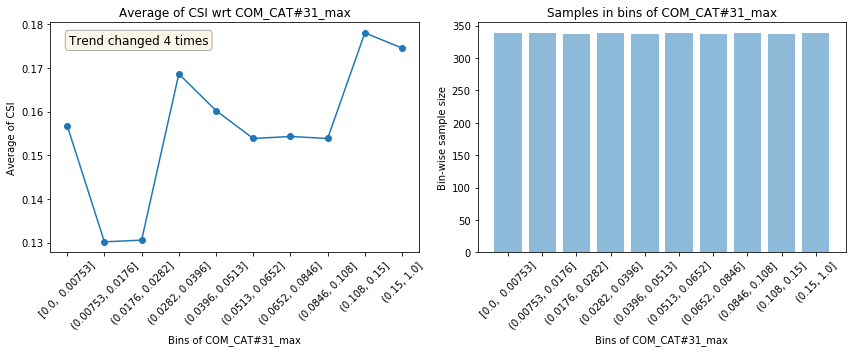

                                           Test data plots                                            


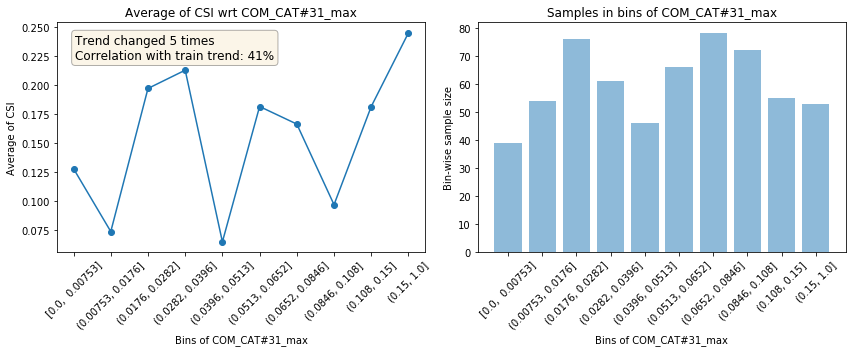

--------------------------------------------------------------------------------------------------------------


                                         Plots for COST_mean                                          
                                           Train data plots                                           


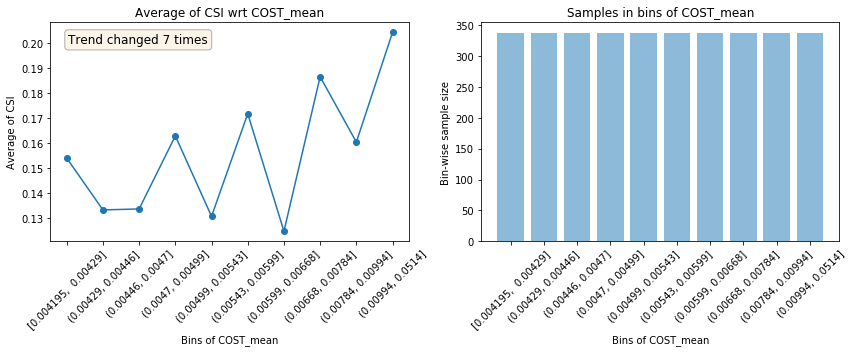

                                           Test data plots                                            


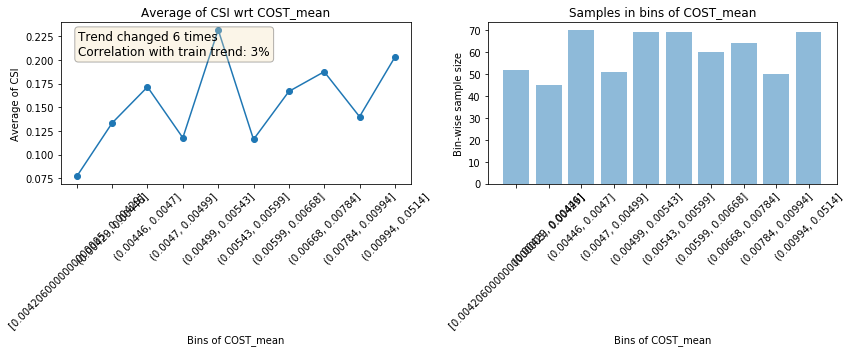

--------------------------------------------------------------------------------------------------------------


                                       Plots for COM_CAT#27_max                                       
                                           Train data plots                                           


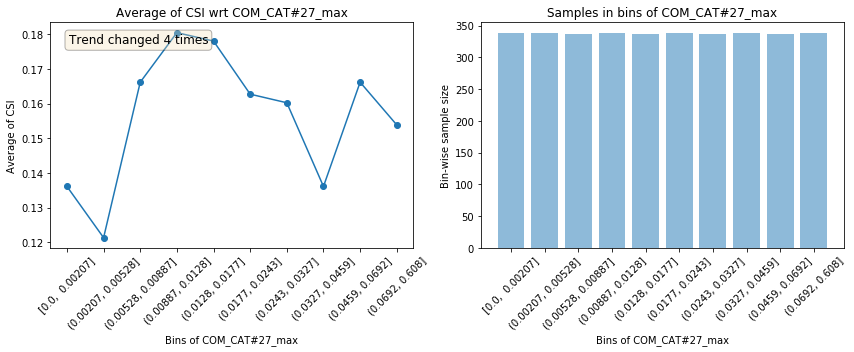

                                           Test data plots                                            


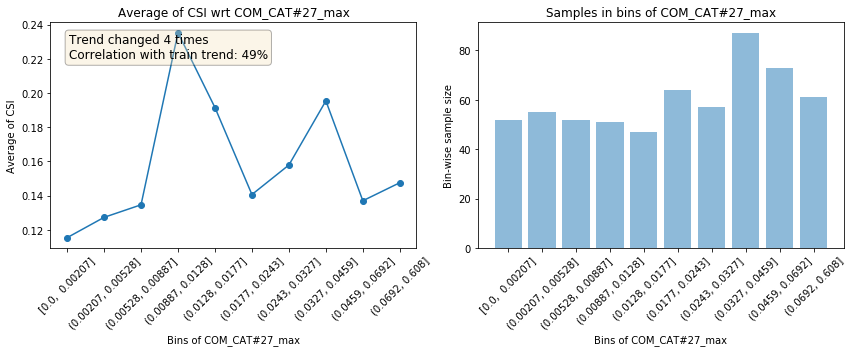

--------------------------------------------------------------------------------------------------------------




In [134]:
get_univariate_plots(data=raw_tr, target_col='CSI', features_list=to_keep, data_test=raw_te)

In [135]:
from featexp import get_trend_stats

In [136]:
get_trend_stats(data=raw_tr, target_col='CSI', features_list=to_keep, data_test=raw_te)

Returning stats for all numeric features


,Feature,Trend_changes,Trend_changes_test,Trend_correlation
0,RENT_CHANNEL_min,6,4,0.804366
1,VAS_max,5,7,0.341697
2,COM_CAT#31_max,4,5,0.413230
3,COST_mean,7,6,0.031269
4,COM_CAT#27_max,4,4,0.499216


In [186]:
m = lgb.LGBMClassifier()
m.fit(X_train, y_train)
print_score(m)

[0.9999757084421613, 0.5010187810063784, 0.968266456858117, 0.83]


In [188]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=10, 
                            oob_score=True)
m.fit(X_train, y_train)
print_score(m)

/Users/alexeydemyanchuk/.virtualenvs/kaggle_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexeydemyanchuk/.virtualenvs/kaggle_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[0.999681569361375, 0.4646748759744862, 0.975609756097561, 0.8275, 0.8075006556517178]



#### T statistics 

In [194]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=40, max_features=0.5, min_samples_leaf=50)
m.fit(X_train, y_train)
print_score(m)

[0.8652214321298655, 0.4589804049109684, 0.8458344865762524, 0.8366666666666667]


In [201]:
m = lgb.LGBMClassifier()
m.fit(X_train, y_train)
print_score(m)

[0.9995440929157031, 0.5482761741018912, 0.9597156398104265, 0.8516666666666667]


In [195]:
m_A = RandomForestClassifier(n_jobs=-1, n_estimators=40, max_features=1, min_samples_leaf=50)

In [196]:
m_B = RandomForestClassifier(n_jobs=-1, n_estimators=40, max_features=1, min_samples_leaf=50)

In [197]:
scoring =  metrics.make_scorer(metrics.roc_auc_score, needs_proba=True)

scores_A = np.array([])
scores_B = np.array([])

In [198]:
for i in range(10):
    fold = sklearn.model_selection.KFold(
        n_splits=5, shuffle=True, random_state=i)

    current_scores_A = sklearn.model_selection.cross_val_score(
        estimator=m_A, X=df, y=y, cv=fold, scoring=scoring, n_jobs=-1)

    scores_A = np.append(scores_A, current_scores_A)

    current_scores_B = sklearn.model_selection.cross_val_score(
        estimator=m_B, X=df_keep, y=y, cv=fold, scoring=scoring, n_jobs=-1)

    scores_B = np.append(scores_B, current_scores_B)
    
ttest_rel(scores_A, scores_B)

Ttest_relResult(statistic=0.2916208816968436, pvalue=0.7718075483320691)

In [199]:
scores_A.mean(), margin_of_error(0.975, scores_A)

(0.5358147476585884, 0.006158242445998624)

In [200]:
scores_B.mean(), margin_of_error(0.975, scores_B)

(0.5350650281825832, 0.0065398218267737)

 - last 5 months vs full data `Ttest_relResult(statistic=-0.5739371988382607, pvalue=0.5686356084768682)`
 - last 5 months vs last 8 months `Ttest_relResult(statistic=0.6013845705864069, pvalue=0.5503561387167131)`
 - last 5 months vs last 3 months `Ttest_relResult(statistic=0.7411994751002573, pvalue=0.46211007794300796)`
 - last 5 months vs last 1 month `Ttest_relResult(statistic=0.23439294381926984, pvalue=0.8156565977942658)`
 - **last 5 months vs first 7 months** `Ttest_relResult(statistic=-4.606351117888431, pvalue=2.940069851986962e-05)`
 - last 5 months vs Nov-Mar `Ttest_relResult(statistic=0.538136115643363, pvalue=0.5929192015989826)`
 - last 5 months vs first 10 months `Ttest_relResult(statistic=-0.5254235366522199, pvalue=0.6016584866362571)`
 - **last 5 months vs Jan-Mar** `Ttest_relResult(statistic=4.410632452196336, pvalue=5.6370093653997715e-05)`
 - **last 5 months vs last 2 months** `Ttest_relResult(statistic=1.9717617159255272, pvalue=0.05429614296591497)`

In [202]:
df_keep.shape, y.shape

((3976, 11), (3976,))

In [203]:
# in case you allready have scores_A
m_B = lgb.LGBMClassifier()
scoring =  metrics.make_scorer(metrics.roc_auc_score, needs_proba=True)
scores_B = np.array([])

for i in range(10):
    fold = sklearn.model_selection.KFold(
        n_splits=5, shuffle=True, random_state=i)

    current_scores_B = sklearn.model_selection.cross_val_score(
        estimator=m_B, X=df_keep, y=y, cv=fold, scoring=scoring, n_jobs=-1)

    scores_B = np.append(scores_B, current_scores_B)
    
ttest_rel(scores_A, scores_B)

Ttest_relResult(statistic=-1.7363571239660691, pvalue=0.08878494564496622)

In [204]:
scores_A.mean(), margin_of_error(0.975, scores_A)

(0.53988555034028, 0.005483348192116968)

In [205]:
scores_B.mean(), margin_of_error(0.975, scores_B)

(0.5458719949508225, 0.006588983839327142)

#### Cross-val predict #todo: make 10 seeds

In [252]:
m = lgb.LGBMClassifier()

In [41]:
scoring =  {'roc_auc': metrics.make_scorer(metrics.roc_auc_score, needs_proba=True)}

In [254]:
scores = sklearn.model_selection.cross_validate(
    m, df_keep, y, cv=5, scoring=scoring,
    return_train_score=True, return_estimator=True)

In [255]:
scores['train_roc_auc'].mean(), margin_of_error(0.975, scores['train_roc_auc'])

(0.9999970014694396, 2.662000226861619e-06)

In [256]:
scores['test_roc_auc'].mean(), margin_of_error(0.975, scores['test_roc_auc'])

(0.5208320020492699, 0.014217074471451045)

In [216]:
pred_y = np.zeros(len(test))
for est in scores['estimator']:
    pred_y += est.predict_proba(test[to_keep])[:,1] / 5

In [146]:
df_keep.shape, test[keep_cols].shape

((3976, 10), (5221, 10))

In [207]:
scoring =  {'roc_auc': metrics.make_scorer(metrics.roc_auc_score, needs_proba=True)}
scores_ovaerall_tr = np.array([])
scores_ovaerall_val = np.array([])
pred_y = np.zeros((len(test), 10))

for i in range(10):
    m = RandomForestClassifier(n_jobs=-1, n_estimators=80, max_features=0.5, min_samples_leaf=80)
    
    fold = sklearn.model_selection.KFold(
        n_splits=5, shuffle=True, random_state=i)
    
    scores = sklearn.model_selection.cross_validate(
        m, df_keep, y, cv=fold, scoring=scoring,
        return_train_score=True, return_estimator=True, n_jobs=-1)
    
    scores_ovaerall_tr = np.append(scores_ovaerall_tr, scores['train_roc_auc'])
    scores_ovaerall_val = np.append(scores_ovaerall_val, scores['test_roc_auc'])
    
    for est in scores['estimator']:
        pred_y[:,i] += est.predict_proba(test[to_keep])[:,1] / 5

In [208]:
scores_ovaerall_tr.mean(), margin_of_error(0.975, scores_ovaerall_tr)

(0.8024462506865184, 0.002451370805024379)

In [209]:
scores_ovaerall_val.mean(), margin_of_error(0.975, scores_ovaerall_val)

(0.5246803267351363, 0.006506372891543862)

In [156]:
pred_y = pred_y.mean(axis=1)

### Predict on test and submit

In [58]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=100, min_samples_leaf=12, max_features=0.8, 
                           random_state=111)
m.fit(df, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=12, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=111, verbose=0, warm_start=False)

In [173]:
m = lgb.LGBMClassifier()
m.fit(df, y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [59]:
pred_y = m.predict_proba(test)[:,1]

In [157]:
subm = pd.DataFrame(pred_y)

In [158]:
subm.shape

(5221, 1)

In [159]:
subm.to_csv('submits/rf_underfit3_cv_first7_fi_5_keep_cols.csv', index=False, header=False)

### Local Validation vs LB

- 'lgb_t-test_val_full_last5 months' local predict, ci: (0.5216179343069107, 0.006672037004185105); LB:0.51221
- 'lgb_t-test_val_full_first7'     local predict, ci: (0.5384367387214946, 0.005560330542734631); LB:0.53891
- 'lgb_t-test_val_full_first7+id'    local predict, ci: (0.5385112223124687, 0.0055238218737344); LB:0.53546
- *'lgb_t-test_val_full_first7+id+fi' local predict, ci: (0.5474994543180034, 0.005521392094374423); LB:0.51444*
- 'lgb_t-test_val_full_first7_fi'    local predict, ci: (0.5459079501018401, 0.005487685723475682); LB:0.52712

 - lgb_cv_full_first7 local predict, ci: (0.52633, 0.01120); LB:0.53010
 - **lgb_cv_full_first7_fi63 'not zero fi' local predict, ci: (0.54592, 0.00548); LB:0.52488**
 - lgb_cv_full_first7_fi_dendr local predict, ci: (0.53335, 0.00600); LB:0.52541
 - **lgb_cv_full_first7_fi_13_keep_cols local predict, ci: (0.54323, 0.00722); LB:0.51444**
 - **lgb_cv_full_first7_fi_11_keep_cols local predict, ci: (0.54587, 0.00658); LB:0.50950**

 - rf_underfit_cv_first7_fi_not_0 local predict, ci: (0.55890, 0.00582); LB:0.52541
 - rf_underfit1_cv_first7_fi_not_0 local predict, ci: (0.55064, 0.00608); LB:0.51319
 - rf_underfit2_cv_first7_fi_11_keep_cols local predict, ci: (0.55757, 0.00547); LB:0.51943